In [24]:
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()

## 문제: 월드컵 데이터 JSON의 URL에서 DataFrame 생성

url에서 데이터를 직접 읽어 DataFrame을 생성하는 방법은 지원되지 않고 있다.
requests 라이브러리를 사용하여, url에서 데이터를 가져오고, DataFrame을 생성하여 보자.


In [294]:
import requests

r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json()


#### 별표 1개 ```*```: **리스트**에서 인자 풀어내기
리스트를 넘겨주고 여기서 풀어서 하나씩 인자를 사용할 경우 * 를 사용!


In [295]:
#ex1)
myList = [1,6]
print(list(range(1,6)))
print(list(range(*myList)))

[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]


In [296]:
#ex2) 파라미터에는 하나씩 숫자가 넘어 가야 한다. 한번에 넘겨주고 싶으면 *파라미터에을 붙여라 
def f(args):
    for i in args:
        print(i, end="~")

f(0, 1, 2, 3)


TypeError: f() takes 1 positional argument but 4 were given

In [297]:
# 수정
def f(*args):
    for i in args:
        print(i, end="~")

f(0, 1, 2, 3)

0~1~2~3~

#### 별표 2 개 ```**```: **dictionary**에서 인자 풀어내기

dictionary를 넘겨주고 여기서 key, value를 하나씩 사용할 경우 ```**```를 사용한다.

In [298]:
#ex 1)
def d(name, day):
    print(f"{name} 게릿 {day}")
myDict = {"name": "d","day":"c"}
d(**myDict)

d 게릿 c


In [299]:
#ex 2) json으로 읽어온 wc를(안에 딕셔너리 여러개로 구성) 하나씩 읽어준다. 
from pyspark.sql import Row

wcDf = spark.createDataFrame(Row(**x) for x in wc)
wcDf.printSchema()

root
 |-- Competition: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Team: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)



#### RDD 통해 dataframe 생성

In [300]:
rdd = spark.sparkContext.parallelize(wc)  
df = spark.createDataFrame(rdd)
df.printSchema()


root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)



## 결측값
null -> no value 또는 nothing
NaN -> 수학에서 0.0과 같이 의미가 없는 연산의 결과
isCaptain

In [301]:
from pyspark.sql.functions import isnan, when, count, col
cols = wcDf.columns
cols.remove('IsCaptain')

wcDf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols]).show()

+-----------+----+----+------+--------+--------+----+-----------+-----------+
|Competition|Year|Team|Number|Position|FullName|Club|ClubCountry|DateOfBirth|
+-----------+----+----+------+--------+--------+----+-----------+-----------+
|          0|   0|   0|     0|       0|       0|   0|          0|          0|
+-----------+----+----+------+--------+--------+----+-----------+-----------+



## 형변환

스키마를 자동으로 유추한 형식을 보면,
DateOfBirth, Number 컬럼이 문자열로 인식되어 있어 만족스럽지 못하다.
컬럼 'DateOfBirth'는 'DoB'로 ```DateType()```, 컬럼 'Number'는 'NumberInt'로 "Integer" 형으로 설정해보자.

### 1. udf(사용자 함수) 사용

In [302]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType
toDate = udf(lambda x: datetime.striptime(x,'%m/%d/%y'), DateType())
wcDf = wcDf.withColumn('date1',toDate(wcDf['DateOfBirth']))
wcDf.printSchema()

root
 |-- Competition: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Team: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- date1: date (nullable = true)



### 2. pyspark -> to_date() 함수 사용

In [306]:
from pyspark.sql.functions import to_date
#date1 지워!
wcDf = wcDf.drop('date1')
_wcDfCasted=wcDf.withColumn("date2", to_date(wcDf['DateOfBirth'], 'yyyy-MM-dd'))
_wcDfCasted.collect()

Py4JJavaError: An error occurred while calling o4064.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 281.0 failed 1 times, most recent failure: Lost task 0.0 in stage 281.0 (TID 1729) (10.17.141.84 executor driver): org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '1905-5-5' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:345)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	at java.base/java.lang.Thread.run(Thread.java:832)
Caused by: java.time.format.DateTimeParseException: Text '1905-5-5' could not be parsed at index 5
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2051)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1879)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:775)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at jdk.internal.reflect.GeneratedMethodAccessor129.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:564)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:832)
Caused by: org.apache.spark.SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0: Fail to parse '1905-5-5' in the new parser. You can set spark.sql.legacy.timeParserPolicy to LEGACY to restore the behavior before Spark 3.0, or set to CORRECTED and treat it as an invalid datetime string.
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:150)
	at org.apache.spark.sql.catalyst.util.DateTimeFormatterHelper$$anonfun$checkParsedDiff$1.applyOrElse(DateTimeFormatterHelper.scala:141)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:86)
	at scala.runtime.java8.JFunction0$mcJ$sp.apply(JFunction0$mcJ$sp.java:23)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.parse(TimestampFormatter.scala:77)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$getByteArrayRdd$1(SparkPlan.scala:345)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:898)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:898)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1130)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:630)
	... 1 more
Caused by: java.time.format.DateTimeParseException: Text '1905-5-5' could not be parsed at index 5
	at java.base/java.time.format.DateTimeFormatter.parseResolved0(DateTimeFormatter.java:2051)
	at java.base/java.time.format.DateTimeFormatter.parse(DateTimeFormatter.java:1879)
	at org.apache.spark.sql.catalyst.util.Iso8601TimestampFormatter.$anonfun$parse$1(TimestampFormatter.scala:78)
	... 20 more


### 3. pyspark의 cast 함수 사용

In [35]:
from pyspark.sql.types import DateType

wcDfCasted = _wcDfCasted.withColumn('date3',wcDf['DateOfBirth'].cast(DateType()))
wcDfCasted = wcDfCasted.withColumn('NumberInt', wcDfCasted['Number'].cast("integer"))
wcDfCasted.printSchema()

root
 |-- Competition: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Team: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- date2: date (nullable = true)
 |-- date3: date (nullable = true)
 |-- NumberInt: integer (nullable = true)



## 다시 풀어!!
여기서는 rdd 만들필요없이 dataframe 만들때 그냥 바로 json데이터를 row로 넘긴뒤 바로 생성 

## 최종 정리: 월드컵 데이터 문제에 대한 정답
###   df를 만드는것 뿐 만 아니라 datatime도 정의하고 행 추가해라

In [36]:
import os
import requests
from pyspark.sql import Row
from pyspark.sql.types import DateType
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()

#json data 가져오기

r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
data = r.json()

# #rdd 생성 
# rdd = spark.sparkContext.parallelize(data)

#df 생성 생성시 Row사용
df = spark.createDataFrame(Row(**x) for x in data)

#data 타입 변환
dfcasted = df.withColumn("date1", df['DateOfBirth'].cast(DateType()))
dfcasted.take(1)

[Row(Competition='World Cup', Year=1930, Team='Argentina', Number='', Position='GK', FullName='Ãngel Bossio', Club='Club AtlÃ©tico Talleres de Remedios de Escalada', ClubCountry='Argentina', DateOfBirth='1905-5-5', IsCaptain=False, date1=datetime.date(1905, 5, 5))]

# dataFrame APi

### 1. 빈 dataframe 만들기 

In [37]:
from pyspark.sql.types import StructType

schema = StructType([])
emptyDf = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)
emptyDf.printSchema()

root



### 2. range -> 파라미터(시작 숫자, 마지막 숫자(범위), 더하는 크기) 
row에 자동으로 id 라는 row 들어온다.

dataframe 생성 안하고 만들 수 있다.

In [38]:
spark.range(0, 10, 3).show()

+---+
| id|
+---+
|  0|
|  3|
|  6|
|  9|
+---+



### 3. 현재 date 출력

In [39]:
from pyspark.sql import functions as F
spark.range(1).select(F.unix_timestamp().alias("current_timestamp")).show()

+-----------------+
|current_timestamp|
+-----------------+
|       1634908589|
+-----------------+



### 4. 컬럼추가 withcolumn, 컬럼 삭제 Drop

In [87]:
#로컬에 저장되어있는 csv에서 data 가져와서 바로 dataframe으로 만든다

tDf = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))

In [88]:
#column 생성

tDf = tDf.withColumn("id", tDf['_c0'].cast("integer"))
tDf = tDf.withColumn("height", tDf['_c1'].cast("double"))
tDf = tDf.withColumn("weight", tDf['_c2'].cast('double'))
tDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- id: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



In [89]:
# 컬럼 삭제

tDf = tDf.drop('_c0').drop('_c1').drop('_c2')
tDf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



In [90]:
myDf = spark\
        .read.format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true')\
        .load(os.path.join('data','myDf.csv'))

In [91]:
myDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)




### 5. udf 함수를 이용한 변환

In [70]:
# 대문자 만드는 함수
def uppercase(s):
    return s.upper()

from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
#함수를 udf통해 적용 
upperUdf = udf(uppercase, StringType())
myDf = myDf.withColumn('nameUpper', upperUdf(myDf['name']))
myDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- nameUpper: string (nullable = true)



In [216]:
#double 실수 변환 
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

toDoublefunc = udf(lambda x : float(x), DoubleType())
myDf = myDf.withColumn('heightD', toDoublefunc(myDf['height']))
myDf.show()

+---+----+-------+------+-------+
|_c0|year|   name|height|heightD|
+---+----+-------+------+-------+
|  0|   1|kim, js|   170|  170.0|
|  1|   1|lee, sm|   175|  175.0|
|  2|   2|lim, yg|   180|  180.0|
|  3|   2|    lee|   170|  170.0|
+---+----+-------+------+-------+



In [79]:
#int 정수 변환 
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

toint = udf(lambda x : int(x), IntegerType())
myDf = myDf.withColumn("year1",toint(myDf['year']))
myDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- nameUpper: string (nullable = true)
 |-- heightD: double (nullable = true)
 |-- year1: integer (nullable = true)



In [80]:
myDf.select('year1').show()

+-----+
|year1|
+-----+
|    1|
|    1|
|    2|
|    2|
+-----+



In [84]:
#udf 조건에 따른 변환
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

height_udf = udf(lambda x : "taller" if x >= 175 else "shorter", StringType())
heightDf = myDf.withColumn('height > 175', height_udf(myDf['heightD']))
heightDf.show()


+---+----+-------+------+---------+-------+-----+------------+
|_c0|year|   name|height|nameUpper|heightD|year1|height > 175|
+---+----+-------+------+---------+-------+-----+------------+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|     shorter|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|      taller|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|      taller|
|  3|   2|    lee|   170|      LEE|  170.0|    2|     shorter|
+---+----+-------+------+---------+-------+-----+------------+



### 6. 컬럼명 변경 withColumnRenamed

In [92]:
tDf = tDf.withColumnRenamed('id','ID')
tDf.show(3)

+---+------+------+
| ID|height|weight|
+---+------+------+
|  1| 65.78|112.99|
|  2| 71.52|136.49|
|  3|  69.4|153.03|
+---+------+------+
only showing top 3 rows



# 그래프


### 1. plot

In [110]:
# dataFrame을 rdd 로 변환 -> map 사용해서 height, weight 값 분리 

wrdd = tDf.rdd.map(lambda x : x[1]).collect()
hrdd = tDf.rdd.map(lambda x : x[2]).collect()
print(wrdd)

[65.78, 71.52, 69.4, 68.22, 67.79, 68.7, 69.8, 70.01, 67.9, 66.78, 66.49, 67.62, 68.3, 67.12, 68.28, 71.09, 66.46, 68.65, 71.23, 67.13, 67.83, 68.88, 63.48, 68.42, 67.63, 67.21, 70.84, 67.49, 66.53, 65.44, 69.52, 65.81, 67.82, 70.6, 71.8, 69.21, 66.8, 67.66, 67.81, 64.05, 68.57, 65.18, 69.66, 67.97, 65.98, 68.67, 66.88, 67.7, 69.82, 69.09]


In [117]:
# numpy 사용하여 5번째 까지 출력 
import numpy as np
print(np.array(wrdd)[:5])
print(np.array(hrdd)[:5])

[65.78 71.52 69.4  68.22 67.79]
[112.99 136.49 153.03 142.34 144.3 ]


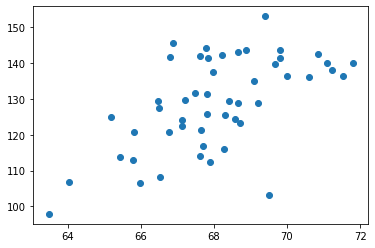

In [120]:
# plot에 적용하여 그래프 그리기 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.array(wrdd), np.array(hrdd),'o')
plt.show()



### 2. boxplot(분위), violinplot(밀도)

In [122]:
height = tDf.select('height').toPandas()
height.describe()

,height
count,50.00000
mean,68.05240
std,1.82398
min,63.48000
25%,66.94000
50%,67.86500
75%,69.18000
max,71.80000


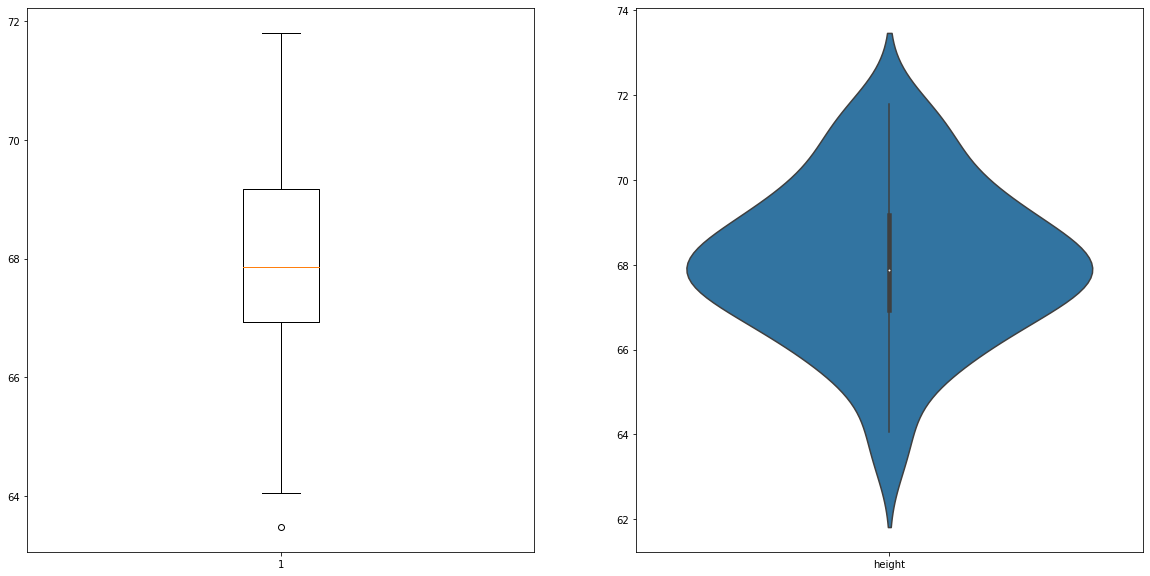

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)  # subplot location
ax1 = plt.boxplot(height)

ax2 = fig.add_subplot(1, 2, 2)
ax2 = sns.violinplot(data=height)

# aggregate functions

### 1. agg -> agg(컬럼명, aggregate functions)

##### 기능들
1. 합 (sum)

2. 첨도 (kurtosis)

3. 평균 (avg)

In [125]:
tDf.agg({'height':'count'}).show()

+-------------+
|count(height)|
+-------------+
|           50|
+-------------+



In [128]:
tDf.agg({"height":"avg"}).show()

+-----------------+
|      avg(height)|
+-----------------+
|68.05240000000002|
+-----------------+



In [129]:
tDf.agg({"height":"kurtosis"}).show()

+--------------------+
|    kurtosis(height)|
+--------------------+
|-0.00944222604387468|
+--------------------+



### 2. F 함수


In [130]:
from pyspark.sql import functions as F
tDf.agg(F.min("height")).show()

+-----------+
|min(height)|
+-----------+
|      63.48|
+-----------+



### 3. select(컬럼 조회)


In [132]:
# 방법 1 직접 조회 하지만 show collect 안댐 
myDf['name'].show()

TypeError: 'Column' object is not callable

In [133]:
# 방법 2 select 사용
myDf.select('name').show()

+-------+
|   name|
+-------+
|kim, js|
|lee, sm|
|lim, yg|
|    lee|
+-------+



In [134]:
# 여러 컬럼 조회
myDf.select('name','height').show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|lee, sm|   175|
|lim, yg|   180|
|    lee|   170|
+-------+------+



In [136]:
# * 활용
ml = ['name','height']
myDf.select(*ml).show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|lee, sm|   175|
|lim, yg|   180|
|    lee|   170|
+-------+------+



### 3-1. 컬럼(Row)을 리스트로 변환

In [162]:
# row를 리스트로 변환 
#1. map에서 인덱스를 사용해서 빼낸다.
myDf.select('name').rdd.map(lambda x : x[0]).collect()

#2. flatmap을 이용하여 빼낸다.
myDf.select('name').rdd.flatMap(lambda x : x).collect()

['kim, js', 'lee, sm', 'lim, yg', 'lee']

### 3-2. select like 

In [167]:
myDf.select("name","height",myDf.name.like("%lee%")).show()

+-------+------+---------------+
|   name|height|name LIKE %lee%|
+-------+------+---------------+
|kim, js|   170|          false|
|lee, sm|   175|           true|
|lim, yg|   180|          false|
|    lee|   170|           true|
+-------+------+---------------+



### 3-3. select startswith

In [168]:
myDf.select('name','height',myDf.name.startswith("kim")).show()

+-------+------+---------------------+
|   name|height|startswith(name, kim)|
+-------+------+---------------------+
|kim, js|   170|                 true|
|lee, sm|   175|                false|
|lim, yg|   180|                false|
|    lee|   170|                false|
+-------+------+---------------------+



### 3-4. select endswith

In [170]:
myDf.select("name","height", myDf.name.endswith("lee")).show()

+-------+------+-------------------+
|   name|height|endswith(name, lee)|
+-------+------+-------------------+
|kim, js|   170|              false|
|lee, sm|   175|              false|
|lim, yg|   180|              false|
|    lee|   170|               true|
+-------+------+-------------------+



## 4. alias(명칭 변경)

In [171]:
# dataframe 명칭 변경 
myDf1 = myDf.alias("myDf1")

In [173]:
#컬럼 명칭 변경
myDf1.select(myDf1.name.substr(1,3).alias("short name")).show()

+----------+
|short name|
+----------+
|       kim|
|       lee|
|       lim|
|       lee|
+----------+



### 5. 행과 열을 선택 select, when, otherwise

In [174]:
from pyspark.sql.functions import when
myDf.select("height", when(myDf.height < 175, 1).otherwise(0)).show()

+------+------------------------------------------+
|height|CASE WHEN (height < 175) THEN 1 ELSE 0 END|
+------+------------------------------------------+
|   170|                                         1|
|   175|                                         0|
|   180|                                         0|
|   170|                                         1|
+------+------------------------------------------+



In [176]:
#alias로 컬럼 변경
from pyspark.sql.functions import when
myDf.select("height", (when(myDf.height < 175, 1).otherwise(0)).alias('<175')).show()

+------+----+
|height|<175|
+------+----+
|   170|   1|
|   175|   0|
|   180|   0|
|   170|   1|
+------+----+



In [180]:
from pyspark.sql.functions import when
_myDf = myDf.select('height', when(myDf['height'] > 175.0, ">175").otherwise("<175").alias("how tall"))

In [181]:
_myDf.show()

+------+--------+
|height|how tall|
+------+--------+
|   170|    <175|
|   175|    <175|
|   180|    >175|
|   170|    <175|
+------+--------+



In [186]:
_myDf = myDf.withColumn('how tall', when(myDf.height > 175.0, "> 175.0").otherwise("< 175.0"))
_myDf.show()

+---+----+-------+------+--------+
|_c0|year|   name|height|how tall|
+---+----+-------+------+--------+
|  0|   1|kim, js|   170| < 175.0|
|  1|   1|lee, sm|   175| < 175.0|
|  2|   2|lim, yg|   180| > 175.0|
|  3|   2|    lee|   170| < 175.0|
+---+----+-------+------+--------+



### 6. 행과 열을 선택  where, select

In [187]:
myDf.where(myDf['height'] < 175).show()

+---+----+-------+------+
|_c0|year|   name|height|
+---+----+-------+------+
|  0|   1|kim, js|   170|
|  3|   2|    lee|   170|
+---+----+-------+------+



In [188]:
myDf.where(myDf['height'] < 175)\
    .select(myDf['name'], myDf['height']).show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|    lee|   170|
+-------+------+



### 7. filter

In [189]:
myDf.filter(myDf['height'] > 175).show()

+---+----+-------+------+
|_c0|year|   name|height|
+---+----+-------+------+
|  2|   2|lim, yg|   180|
+---+----+-------+------+



### 8. regexp_replace 컬럼의 내용 변경

In [201]:
from pyspark.sql.functions import *
#nameNew 컬럼을 추가하고 lee를 다 lim으로 변경 
_heightDf = myDf.withColumn('nameNew', regexp_replace('name', 'lee', 'lim'))
myDf.show()

+---+----+-------+------+
|_c0|year|   name|height|
+---+----+-------+------+
|  0|   1|kim, js|   170|
|  1|   1|lee, sm|   175|
|  2|   2|lim, yg|   180|
|  3|   2|    lee|   170|
+---+----+-------+------+



### 9. groupBy
집단화하면 개수를 세거나 합계를 내거나 어떤 통계량 계산이 필요하다.

In [198]:
myDf.groupby(myDf['year']).max().show()

+----+--------+---------+-----------+
|year|max(_c0)|max(year)|max(height)|
+----+--------+---------+-----------+
|   1|       1|        1|        175|
|   2|       3|        2|        180|
+----+--------+---------+-----------+



In [218]:
myDf.groupBy('year').agg({"heightD":"avg"}).show()

+----+------------+
|year|avg(heightD)|
+----+------------+
|   1|       172.5|
|   2|       175.0|
+----+------------+



#### groupBy 국가별 인원수


In [213]:
wcDf.groupBy(wcDf.ClubCountry).count().show()

+-----------+-----+
|ClubCountry|count|
+-----------+-----+
|   England |    4|
|   Paraguay|   93|
|     Russia|   51|
|        POL|   11|
|        BRA|   27|
|    Senegal|    1|
|     Sweden|  154|
|   Colombia|    1|
|        FRA|  155|
|        ALG|    8|
|   England |    1|
|       RUS |    1|
|     Turkey|   65|
|      Zaire|   22|
|       Iraq|   22|
|    Germany|  206|
|        RSA|   16|
|        ITA|  224|
|        UKR|   38|
|        GHA|    8|
+-----------+-----+
only showing top 20 rows



#### groupBy 국가별 포지션별 인원수

In [215]:
wcDf.groupBy(wcDf['ClubCountry']).pivot('position').count().show()

+-----------+----+----+----+----+----+
|ClubCountry|    |  DF|  FW|  GK|  MF|
+-----------+----+----+----+----+----+
|   England |null|null|   2|null|   2|
|   Paraguay|null|  26|  37|  10|  20|
|     Russia|null|  20|  11|   4|  16|
|        POL|null|   2|   2|   3|   4|
|        BRA|null|   7|   5|   4|  11|
|    Senegal|null|null|null|   1|null|
|     Sweden|null|  40|  47|  25|  42|
|   Colombia|null|null|   1|null|null|
|        ALG|null|   2|null|   6|null|
|        FRA|null|  46|  41|  18|  50|
|   England |null|null|null|null|   1|
|       RUS |null|null|null|   1|null|
|     Turkey|null|  20|  13|  12|  20|
|      Zaire|null|   6|   5|   3|   8|
|       Iraq|null|   6|   4|   3|   9|
|    Germany|null|  64|  51|  16|  75|
|        RSA|null|   5|   2|   3|   6|
|        UKR|null|  13|   7|   4|  14|
|        ITA|null|  74|  42|  19|  89|
|        CMR|null|   1|   1|   1|null|
+-----------+----+----+----+----+----+
only showing top 20 rows



### F 함수

또는 아래와 같이 별도 ```pyspark.sql.functions```을 사용할 수 있다.
앞서 pyspark.sql.functions은 함수이므로, ```from pyspark.sql.functions import split``` 이렇게 한다.
또는 ```from pyspark.sql import functions as F```라고 한다.

In [221]:
from pyspark.sql import functions as F

myDf.agg(F.min(myDf.heightD), F.max(myDf.heightD), F.avg(myDf.heightD), F.sum(myDf.heightD)).show()

+------------+------------+------------+------------+
|min(heightD)|max(heightD)|avg(heightD)|sum(heightD)|
+------------+------------+------------+------------+
|       170.0|       180.0|      173.75|       695.0|
+------------+------------+------------+------------+



## 행 추가

In [232]:
append = spark.createDataFrame([Row(4, 1, "choi, js",177)])
_myDf = myDf.union(append)
_myDf.show()

+---+----+--------+------+
|_c0|year|    name|height|
+---+----+--------+------+
|  0|   1| kim, js|   170|
|  1|   1| lee, sm|   175|
|  2|   2| lim, yg|   180|
|  3|   2|     lee|   170|
|  4|   1|choi, js|   177|
+---+----+--------+------+

